# Diffusivity tensor for any resolution

In [5]:
import numpy as np
import xarray as xr
from funcs import *
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm

In [6]:
Lcoarse = 50e3

In [7]:
Model_Tav = xr.open_dataset('./data/Model_Tav_3D.nc')

In [8]:
Trac_coarse = xr.open_dataset('./data/Trac_coarse_'+str(int(Lcoarse//1e3))+'km_3D.nc')
Vels_coarse = xr.open_dataset('./data/Vels_coarse_'+str(int(Lcoarse//1e3))+'km_3D.nc')

In [9]:
list_trac = ['TRAC01', 'TRAC02', 'TRAC03', 'TRAC04', 'TRAC05', 
            'TRAC06', 'TRAC07', 'TRAC08']

In [10]:
[UpCp, VpCp, WpCp] = get_flux_arrays(Trac_coarse, list_trac)
[dCdx, dCdy, dCdz]= get_grad_arrays(Trac_coarse, list_trac)

In [12]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)

Ktensor = xr.apply_ufunc(calc_tensor, 
                       UpCp,
                       VpCp,
                       WpCp,
                       dCdx,
                       dCdy,
                       dCdz,
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor.load() # need to load because we will take transpose and a

CPU times: user 2.46 s, sys: 14.9 ms, total: 2.47 s
Wall time: 3.11 s


In [13]:
Ktensor_T = Ktensor.transpose('Z','YCcoarse','XCcoarse','j','i')

ST = 0.5*(Ktensor.data + Ktensor_T.data)
AT = 0.5*(Ktensor.data - Ktensor_T.data)

ST = xr.DataArray(ST, coords=Ktensor.coords, dims=Ktensor.dims)
AT = xr.DataArray(AT, coords=Ktensor.coords, dims=Ktensor.dims)

In [14]:
# make sure the eigen values are arranged by magnitude (instead of the default arrangement)
def eigen(A):
    eigenValues, eigenVectors = eigh(A)
    idx = np.argsort(np.abs(eigenValues))
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors)

## Rotation of EVs

## End section of EV rotations. 

In [15]:
# calculate the eigenvalues and eigenvectors of symmetric part
eigvalsST, eigvecsST = xr.apply_ufunc(eigen, ST, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])


In [16]:
diff_tensor = xr.Dataset()
diff_tensor['K'] = Ktensor
diff_tensor['ST'] = ST
diff_tensor['AT'] = AT
diff_tensor['eigvalsST'] = np.real(eigvalsST)
diff_tensor['eigvecsST'] = eigvecsST

In [17]:
diff_tensor.to_netcdf('./data/diff_tensor_'+str(int(Lcoarse//1e3))+'km_3D.nc')

# Some maps to see if the fast or slow restoring has more negative eigenvalues

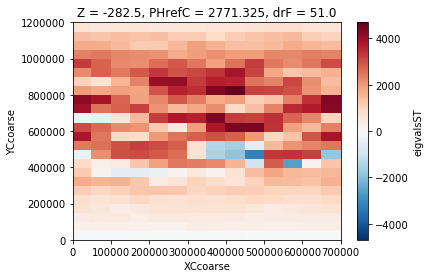

In [19]:
diff_tensor['eigvalsST'].isel(ii=1).sel(Z=-300, method='nearest').plot()

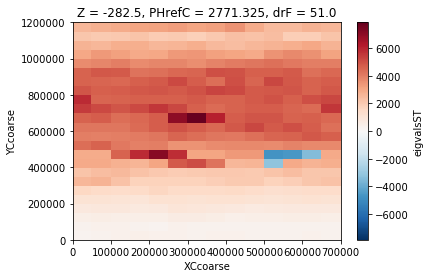

In [22]:
diff_tensor['eigvalsST'].isel(ii=2).sel(Z=-300, method='nearest').plot()

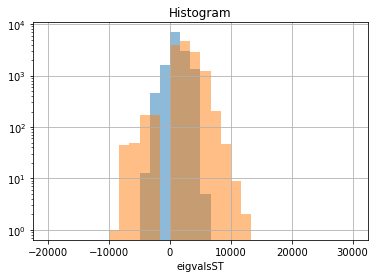

In [21]:
bins = np.linspace(-2e4,3e4,31)

[_,_,_]=diff_tensor['eigvalsST'].isel(ii=1).plot.hist(bins=bins, alpha=0.5)
[_,_,_]=diff_tensor['eigvalsST'].isel(ii=2).plot.hist(bins=bins, alpha=0.5)


plt.yscale('log')
plt.grid()